In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from micron2.clustering import Autoencoder, train_AE_simCLR
from micron2.data import stream_dataset

import tqdm.auto as tqdm

In [2]:
import h5py
f = h5py.File('/dev/shm/dataset.hdf5', 'r')
print(f['meta/channel_names'][:])
use_channels = [b.decode('UTF-8') for b in f['meta/channel_names'][:]]
# fn = lambda x,y: print(x)
print(f.keys())
print(f['cells'].keys())
f.close()

[b'DAPI' b'OX40L' b'CD45' b'CD20' b'CD134' b'CD68' b'CD31' b'CD103'
 b'HLA-DR' b'CXCR5' b'IgG' b'CD3e' b'Ki-67' b'LAG3' b'CXCL13' b'IgA'
 b'CD89' b'PNaD' b'PD-L1' b'PD-1' b'CD11c' b'CD80' b'CD69' b'TIM3'
 b'CD45RO' b'CD40LG' b'FOXP3' b'CD64' b'GZMB' b'C1q' b'CD40' b'CD45RA'
 b'CD138' b'IL7R' b'IgM' b'PDGFRb' b'aSMA' b'CD8' b'CD4' b'PanCytoK']
<KeysViewHDF5 ['cells', 'intensity', 'meta']>
<KeysViewHDF5 ['C1q', 'CD103', 'CD11c', 'CD134', 'CD138', 'CD20', 'CD31', 'CD3e', 'CD4', 'CD40', 'CD40LG', 'CD45', 'CD45RA', 'CD45RO', 'CD64', 'CD68', 'CD69', 'CD8', 'CD80', 'CD89', 'CXCL13', 'CXCR5', 'DAPI', 'FOXP3', 'GZMB', 'HLA-DR', 'IL7R', 'IgA', 'IgG', 'IgM', 'Ki-67', 'LAG3', 'OX40L', 'PD-1', 'PD-L1', 'PDGFRb', 'PNaD', 'PanCytoK', 'TIM3', 'aSMA']>


In [3]:
print(use_channels)
def process(x):
    x = tf.cast(x, tf.float32)/255.
    return x
    
dataset = stream_dataset('/dev/shm/dataset.hdf5', use_channels=use_channels)
dataset = (dataset.repeat(10)
           .shuffle(1024 * 6)
           .map(process)
           .batch(16)
           .prefetch(8)
           #.apply(tf.data.experimental.prefetch_to_device("/gpu:0"))
          )

for sample_x in dataset:
    break
    
print(sample_x.shape)
for k in range(sample_x.shape[-1]):
    print(use_channels[k], sample_x.numpy()[...,k].sum())

['DAPI', 'OX40L', 'CD45', 'CD20', 'CD134', 'CD68', 'CD31', 'CD103', 'HLA-DR', 'CXCR5', 'IgG', 'CD3e', 'Ki-67', 'LAG3', 'CXCL13', 'IgA', 'CD89', 'PNaD', 'PD-L1', 'PD-1', 'CD11c', 'CD80', 'CD69', 'TIM3', 'CD45RO', 'CD40LG', 'FOXP3', 'CD64', 'GZMB', 'C1q', 'CD40', 'CD45RA', 'CD138', 'IL7R', 'IgM', 'PDGFRb', 'aSMA', 'CD8', 'CD4', 'PanCytoK']
(16, 64, 64, 40)
DAPI 2072.451
OX40L 0.0
CD45 389.59607
CD20 47.172554
CD134 0.0
CD68 83.96471
CD31 1.4313726
CD103 0.0
HLA-DR 61.274513
CXCR5 0.0
IgG 155.77257
CD3e 215.66667
Ki-67 1.564706
LAG3 0.0
CXCL13 11.901961
IgA 0.2627451
CD89 0.054901965
PNaD 52.282356
PD-L1 0.0
PD-1 5.933334
CD11c 11.874511
CD80 1.6039217
CD69 0.003921569
TIM3 6.960785
CD45RO 0.0
CD40LG 154.31766
FOXP3 4.8431377
CD64 0.0
GZMB 0.04705883
C1q 38.68628
CD40 0.0
CD45RA 1.9607847
CD138 0.0
IL7R 0.0
IgM 0.0
PDGFRb 0.47450984
aSMA 0.21960786
CD8 35.51765
CD4 311.5451
PanCytoK 44.168633


In [4]:
sample_x = tf.image.random_crop(sample_x, size=(sample_x.shape[0], 48, 48, sample_x.shape[-1]))
ae_model = Autoencoder(input_shape=sample_x.shape[1:])
y, z_g = ae_model(sample_x, return_g=True)
print(y.shape)
print(z_g.shape)
z = ae_model.encode(sample_x)
print(z.shape)

/home/ing/miniconda3/envs/micron2/lib/python3.8/site-packages/tensorflow/python/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 40 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '


(16, 48, 48, 40)
(16, 32)
(16, 256)


In [5]:
ae_model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 2, 2048)        23680832  
_________________________________________________________________
conv2d (Conv2D)              multiple                  2097408   
_________________________________________________________________
g_simclr (Dense)             multiple                  8224      
_________________________________________________________________
conv2d_transpose (Conv2DTran multiple                  2097408   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr multiple                  295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr multiple                  204864    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr multiple                  

In [ ]:
train_AE_simCLR(dataset, ae_model)

In [ ]:
def process(x):
    # x = tf.image.random_crop(x, size=(x.shape[0], 48, 48, x.shape[-1]))
    x = tf.cast(x, tf.float32)/255.
    return x
    
# use_channels=['DAPI', 'CD45', 'PanCytoK']
# use_channels=['DAPI', 'CD45', 'PanCytoK', 'CD31', 'PDGFRb', 'aSMA', 'Ki-67']
dataset = stream_dataset('tests/dataset.hdf5', use_channels = use_channels)
dataset = (dataset.map(process)
           .batch(64)
          )

z = []
for batch in tqdm.tqdm(dataset):
    z.append(ae_model.encode_g(batch).numpy().copy())
    
z = np.concatenate(z, axis=0)
print(z.shape)
print((z.sum(0)==0).sum())

channel 0	pred 0.05	real 1096.72
channel 1	pred 0.07	real 0.00
channel 2	pred 0.05	real 239.03
channel 3	pred 0.02	real 32.00
channel 4	pred 0.04	real 0.00
channel 5	pred 0.01	real 73.04
channel 6	pred 0.11	real 0.20
channel 7	pred 0.02	real 0.00
channel 8	pred 0.04	real 37.47
channel 9	pred 0.06	real 0.00
channel 10	pred 0.00	real 177.25
channel 11	pred 0.03	real 106.45
channel 12	pred 0.06	real 0.55
channel 13	pred 0.04	real 0.00
channel 14	pred 0.07	real 0.39
channel 15	pred 0.02	real 0.00
channel 16	pred 0.03	real 0.00
channel 17	pred 0.05	real 9.73
channel 18	pred 0.05	real 0.00
channel 19	pred 0.10	real 0.55
channel 20	pred 0.02	real 12.18
channel 21	pred 0.07	real 1.97
channel 22	pred 0.02	real 0.00
channel 23	pred 0.02	real 1.49
channel 24	pred 0.04	real 0.00
channel 25	pred 0.02	real 52.58
channel 26	pred 0.10	real 1.65
channel 27	pred 0.06	real 0.00
channel 28	pred 0.07	real 0.04
channel 29	pred 0.11	real 29.64
channel 30	pred 0.07	real 0.00
channel 31	pred 0.04	real 0.89
cha

<Figure size 432x288 with 0 Axes>

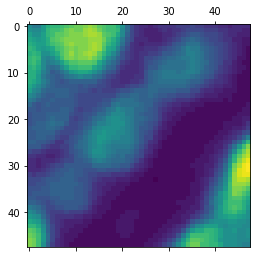

<Figure size 432x288 with 0 Axes>

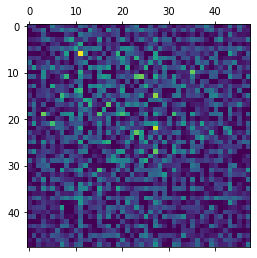

In [6]:
from matplotlib import pyplot as plt
sample_xout = ae_model(sample_x)
for j in range(sample_x.shape[-1]):
    print(f'channel {j}\t' +\
          f'pred {tf.reduce_sum(sample_xout[...,j]).numpy():<4.2f}\t' +\
          f'real {tf.reduce_sum(sample_x[...,j]).numpy():<4.2f}')

idx = np.random.choice(sample_xout.shape[0])
jdx = np.random.choice(sample_xout.shape[-1])

jdx = 0 # DAPI

print(idx, jdx)
sx = sample_x.numpy()[idx, :,:, jdx]
sxout = sample_xout.numpy()[idx, :,:, jdx] 
print(jdx, sx.sum(), sxout.sum())

plt.figure()
plt.matshow(sx)# / sx.max())

plt.figure()
plt.matshow(sxout)# / sxout.max())